# Online Store Customer Segmentation Analysis

## 1. Introduction

<span style='font-family:"Times New Roman"; font-size:12pt;'>
Customer Segmentation is the subdivision of a market into discrete customer groups that share similar characteristics. Customer Segmentation can be a powerful tool to identify unsatisfied customer needs. Using the above data companies can then outperform the competition by developing uniquely appealing products and services.<br><br>The most common ways in which businesses segment their customer base are:  <br>1. Demographic information, such as gender, age, familial and marital status, income, education, and occupation.  <br>2. Geographical information, which differs depending on the scope of the company. For localized businesses, this info might pertain to specific towns or counties. For larger companies, it might mean a customer’s city, state, or even country of residence.<br>3. Psychographics, such as social class, lifestyle, and personality traits.<br>4. Behavioral data, such as spending and consumption habits, product/service usage, and desired benefits.<br><br>In this project I will perform customer segmentation based on a behavioral data.</span>

## 2. Methodology

Since the project is devoted to behavioral analytics I would like to start with one of the most popular tecnhiques in behavioral analytics - cohort analysis. Cohort analysis takes the data from a given eCommerce platform, web application, or online game and rather than looking at all users as one unit, it breaks them into related groups for analysis. These related groups, or cohorts, usually share common characteristics or experiences within a defined time-span. 

In our case cohort analysis is only a preliminary step. It will help me understand better the dataset and will give me some initial insights about customers' behaviour.

Customer segmentation itself will be done in two steps: 1. RFM analysis - traditional and still the most popular technique for customer segmentation. RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement. 2. K-means clustering based on results of RFM analysis. K-means clustering is an unsupervised machine learning technique. 

One of the objectives of this project is to define if two-step customer segmentation (RFM + K-means) is able to provide more valuable insights (in terms of marketing) than just a classic RFM analysis alone.

## 3. Data

I will be working with data from Sprocket Central Pty Ltd , a medium size bikes & cycling australian online store. Data file consists of 3 tables: 
1. Table with 16000 transactions from 01.01.2017 to 31.12.2017. This is the main table I will be working with to segment customers based on their consumption habits. 

2. Table with demographic data of more than 3k customers. I will not segment customers on demographic data. Although this data will be incredibly useful to describe and understand future segments better, how to target them and so on. 

3.Table with geographical data - there are adresses of each customer. It will be interesting to find out if there are any geography related patterns or insights

## 4. Data Preprocessing

Data preproccesing is a necessary step for any data science project. Наш проект не является исключением. В этом разделе мы внимательно ознакомимся с имеющимися данными, проверим готовы ли переменные к анализу и если нет, то сами сделаем это

In [212]:
#First we need to import libraries we will be working with
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [213]:
#Reading the data. Creating 3 pandas dataframes out of 3 initial excel sheets
xls = pd.ExcelFile('store_data.xls')
trans = pd.read_excel(xls, "Transactions")
demo = pd.read_excel(xls, "CustomerDemographic")
address = pd.read_excel(xls, "CustomerAddress")

In [214]:
#Let's take a first look at 3 dataframes
print("TRANSACTIONS DATAFRAME\n") 
print(trans.head())
print()
print("DEMOGRAPHICS DATAFRAME\n") 
print(demo.head())
print()
print("ADDRESSES DATAFRAME\n") 
print(address.head())

TRANSACTIONS DATAFRAME

   transaction_id  product_id  customer_id transaction_date  online_order  \
0               1           2         2950       2017-02-25           0.0   
1               2           3         3120       2017-05-21           1.0   
2               3          37          402       2017-10-16           0.0   
3               4          88         3135       2017-08-31           0.0   
4               5          78          787       2017-10-01           1.0   

  order_status           brand product_line product_class product_size  \
0     Approved           Solex     Standard        medium       medium   
1     Approved   Trek Bicycles     Standard        medium        large   
2     Approved      OHM Cycles     Standard           low       medium   
3     Approved  Norco Bicycles     Standard        medium       medium   
4     Approved  Giant Bicycles     Standard        medium        large   

   list_price  product_first_sold_date  
0        17.6              

Transactional data is the most important for our analysis. Let's take a closer look at a summary of the dataframe.

In [215]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16451 entries, 0 to 16450
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   transaction_id           16451 non-null  int64         
 1   product_id               16451 non-null  int64         
 2   customer_id              16451 non-null  int64         
 3   transaction_date         16451 non-null  datetime64[ns]
 4   online_order             16156 non-null  float64       
 5   order_status             16451 non-null  object        
 6   brand                    16294 non-null  object        
 7   product_line             16294 non-null  object        
 8   product_class            16294 non-null  object        
 9   product_size             16294 non-null  object        
 10  list_price               16451 non-null  float64       
 11  product_first_sold_date  16294 non-null  float64       
dtypes: datetime64[ns](1), float64(3)

Well, there are 16451 transactions. A few columns have missing values, but not too many

In [216]:
trans['order_status'].unique()

array(['Approved', 'Cancelled'], dtype=object)

Some orders were canceled. We don't need canceled orders for our analysis. Let's drop them

In [217]:
trans=trans[trans['order_status']=='Approved']

In [218]:
#checking how many transactions left
len(trans)

16300

In [219]:
#It is time to drop all columns that are irrelevant for our analysis
trans=trans[['transaction_id','customer_id','transaction_date','list_price']]
demo=demo[['customer_id','gender','age','job_industry_category','wealth_segment','owns_car']]
address=address[['customer_id','postcode','property_valuation']]

In [220]:
#Let's merge two customer level tables
cust = pd.merge(demo,address, on='customer_id', how='inner')

In [221]:
#checking new table
print(cust.head())

   customer_id  gender  age job_industry_category     wealth_segment owns_car  \
0            1  Female   67                Health      Mass Customer      Yes   
1            2    Male   40    Financial Services      Mass Customer      Yes   
2            4    Male   59                    IT      Mass Customer       No   
3            5  Female   43                   NaN  Affluent Customer      Yes   
4            6    Male   54                Retail     High Net Worth      Yes   

   postcode  property_valuation  
0      2016                  10  
1      2153                  10  
2      4211                   9  
3      2448                   4  
4      3216                   9  


Now let's take a closer look at cust table variables. Maybe we will need to clean the data.

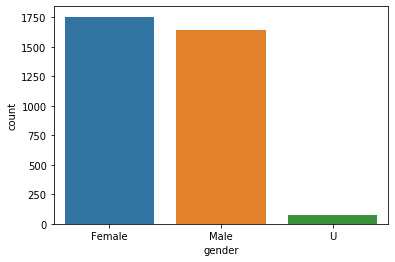

In [222]:
#starting with gender
sns.countplot(cust['gender'])
plt.show()

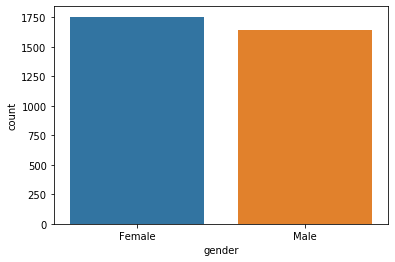

In [223]:
#Let's get rid of instances with U gender
cust = cust[cust['gender'] != 'U']
sns.countplot(cust['gender'])
plt.show()

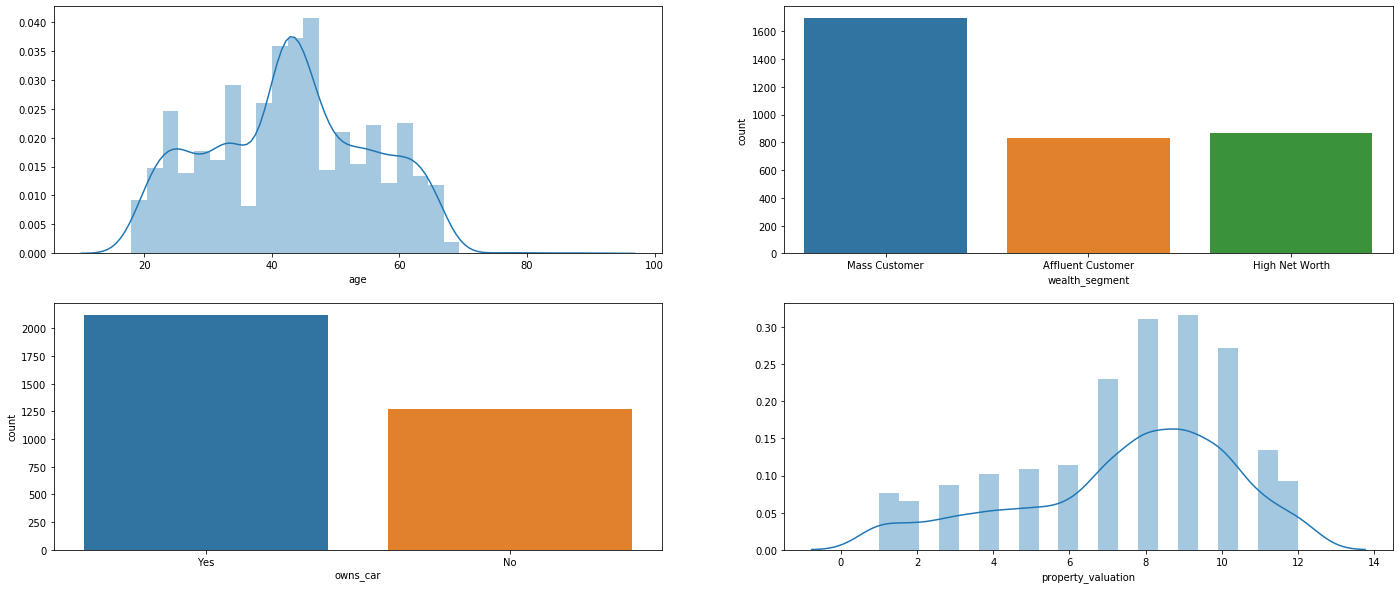

In [224]:
#Let's take a look at the rest variables
plt.figure(figsize=(24,10))
plt.subplot(2, 2, 1)
sns.distplot(cust['age'])
plt.subplot(2, 2, 2)
sns.countplot(cust['wealth_segment'])
plt.subplot(2, 2, 3)
sns.countplot(cust['owns_car'])
plt.subplot(2, 2, 4)
sns.distplot(cust['property_valuation'])
plt.show()

Rest variables seem to be fine. We can start our analysis

## 5.Cohort Analysis

Cohort analysis is a subset of behavioral analytics that measures user engagement over time. It is often used to understand seasonality, customer lifecycle and the long term health of the business. 
A cohort is a group of people who share something in common within a defined time-span. The 2 most common cohort types are:

Acquisition cohorts: Groups divided based on when they signed up for your product
Behavioral cohorts: Groups divided based on their behaviors and actions in your product

We will group customers on acquisition cohorts trying to get some insights about customers' lifecycle and business stability

What we need to do first is to segment customers into cohorts based on the month of their first purchase. Then we will assign the cohort index to each purchase of the customer, which will show the number of months since the first transaction

In [225]:
# From the date column we need only month. Let's make a column for month
def get_month(x): return dt.datetime(x.year, x.month, 1) 

trans['invoice_month'] = trans['transaction_date'].apply(get_month) 

# Now we are grouping by customer_id and selecting the InvoiceMonth value
grouping = trans.groupby('customer_id')['invoice_month'] 

# Assigning a minimum InvoiceDay value to the dataset
trans['cohort_month'] = grouping.transform('min')

In [226]:
# Now we need to calculate time offset in months
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

invoice_year, invoice_month = get_date_int(trans, 'invoice_month')
cohort_year, cohort_month = get_date_int(trans, 'cohort_month')

In [227]:
# Calculating difference in years and months
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

# Extracting the difference in days from all previous values
trans['cohort_index'] = years_diff * 12 + months_diff + 1

# Viewing the top 5 rows
print(trans.head())

   transaction_id  customer_id transaction_date  list_price invoice_month  \
0               1         2950       2017-02-25        17.6    2017-02-01   
1               2         3120       2017-05-21       750.3    2017-05-01   
2               3          402       2017-10-16       659.1    2017-10-01   
3               4         3135       2017-08-31       530.3    2017-08-01   
4               5          787       2017-10-01       540.6    2017-10-01   

  cohort_month  cohort_index  
0   2017-02-01             1  
1   2017-01-01             5  
2   2017-01-01            10  
3   2017-02-01             7  
4   2017-01-01            10  


In [228]:
# Let's count monthly active customers from each cohort
gr = trans.groupby(['cohort_month', 'cohort_index'])
cohort = gr['customer_id'].apply(pd.Series.nunique)
cohort= cohort.reset_index()
counts = cohort.pivot(index='cohort_month', columns='cohort_index', values='customer_id')
# Viewing the first 5 cohorts
print(counts.head())

cohort_index      1      2      3      4      5      6      7      8      9   \
cohort_month                                                                   
2017-01-01    1156.0  362.0  373.0  368.0  361.0  359.0  383.0  406.0  366.0   
2017-02-01     722.0  258.0  228.0  242.0  229.0  235.0  234.0  215.0  262.0   
2017-03-01     499.0  146.0  154.0  149.0  161.0  158.0  149.0  179.0  168.0   
2017-04-01     373.0  107.0  106.0  141.0  127.0  110.0  134.0  116.0  111.0   
2017-05-01     238.0   73.0   73.0   75.0   69.0   68.0   67.0   74.0    NaN   

cohort_index     10     11     12  
cohort_month                       
2017-01-01    396.0  369.0  379.0  
2017-02-01    227.0  226.0    NaN  
2017-03-01    155.0    NaN    NaN  
2017-04-01      NaN    NaN    NaN  
2017-05-01      NaN    NaN    NaN  


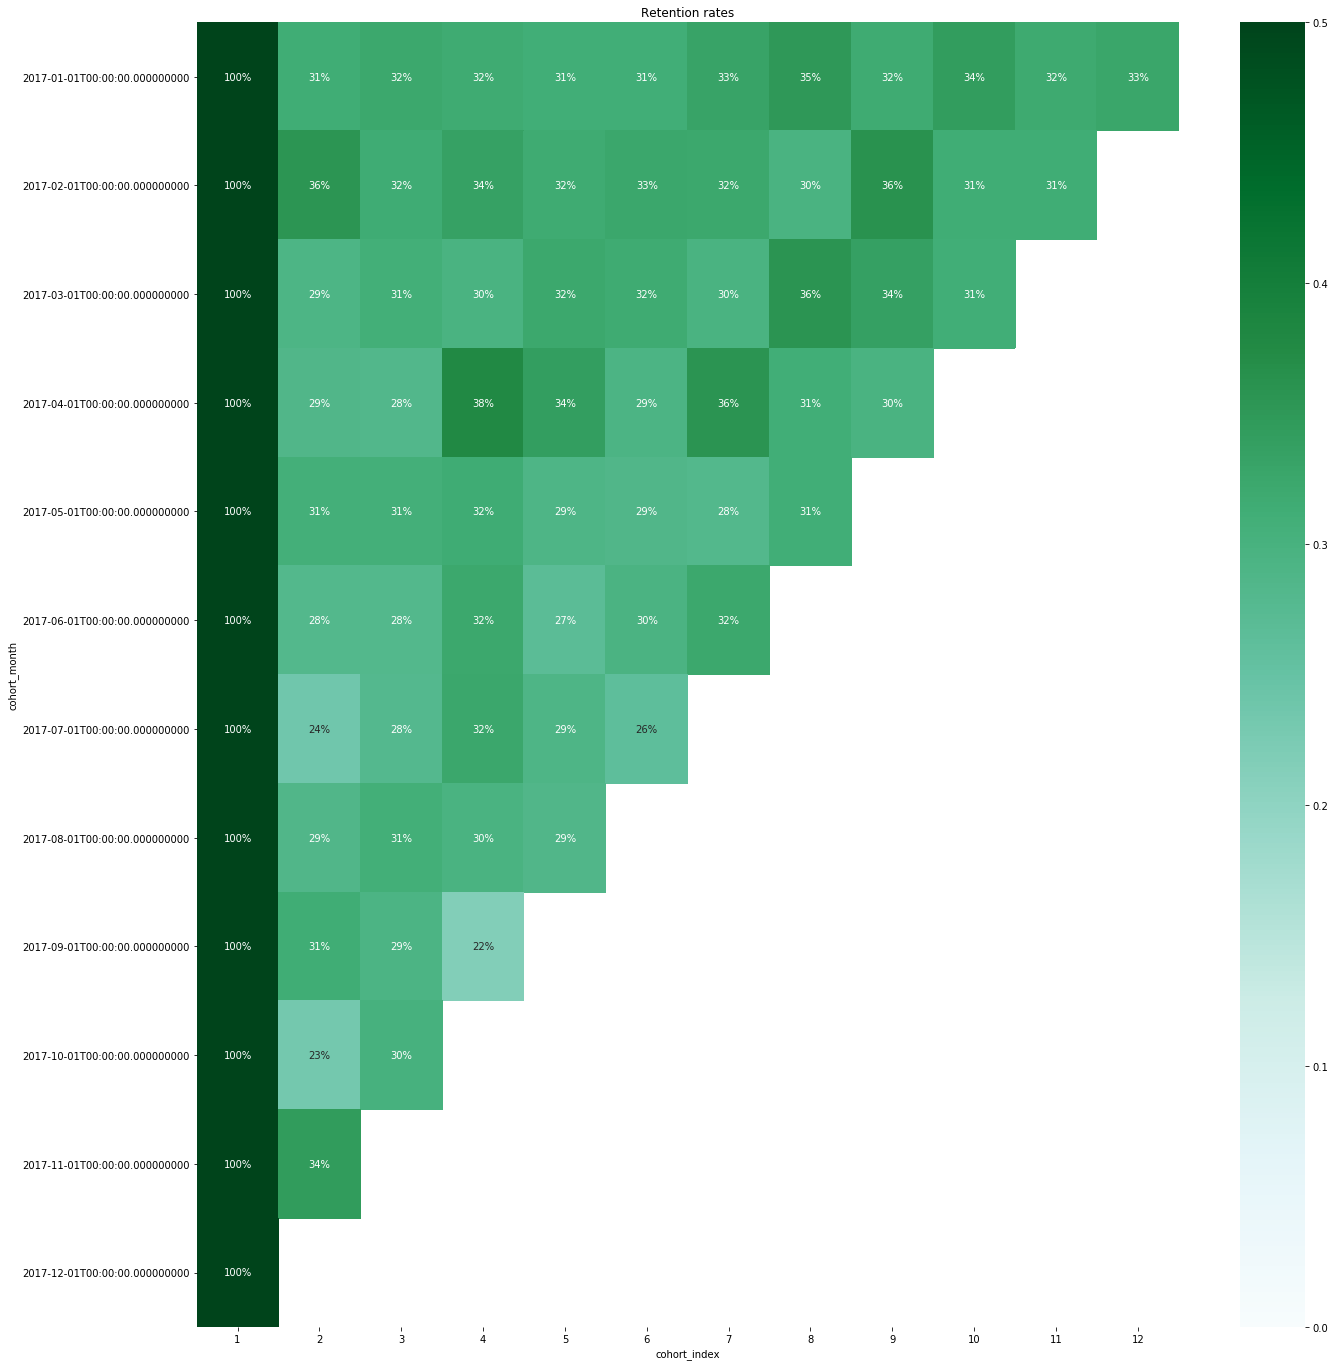

In [229]:
#Calculating retention rates for retention table
sizes = counts.iloc[:,0]
retention = counts.divide(sizes, axis=0)
#Let's finally visualize retention table
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(22, 24))
plt.title('Retention rates')

sns.heatmap(data = retention, annot = True, fmt = '.0%', vmin = 0.0, vmax = 0.5, cmap = 'BuGn')
plt.show()

The rows indicate a timeline and the number of customers the store acquired at each time interval (the who). Each column represents the amount of time that has elapsed since the first purchase (the when). Every cell has the percent of the original acquisition number that has been retained at that period in time.

So, we obtained a very unexpected result. Behaviour of customers does not change both over user lifetime and store lifetime. This means that the online store does a great job in terms of customer retention. We can clearly see from the table that the majority of customers are incredibly loyal and regularly buy from the store. Amazing!

## 6. RFM Analysis

RFM stands for Recency, Frequency and Monetary value. It is time for feature engineering - we need to create these 3 new features(columns). Recency feature depends on reference point - date. Since in real world we would deal with most recent data (not 3 years old data like in our case) let's create a hypothetical snapshot date as if we are doing this analysis recently

In [230]:
print('Min:{}; Max:{}'.format(min(trans["transaction_date"]),max(trans["transaction_date"])))

Min:2017-01-01 00:00:00; Max:2017-12-30 00:00:00


In [231]:
# Creating a hypothetical snapshot_day
snapshot_day = max(trans["transaction_date"]) + dt.timedelta(days=1)

Well, to create these 3 new variables we need to aggregate our dataset on a customer level and:
for Recency - calculate a difference between the snapshot date and date of the most recent order for each customer
for Frequency - count all the orders for each customer
for Monetary value - calculate total sum of spendings for each customer.

However, let's discuss Monetary value variable a little bit. Indeed, in traditional RFM analysis Monetary value stands for a sum of spendings, not an average of spendings. I am absolutely convinced that it is not right! Here is why: there would be a strong correlation between Frequency and Monetary value if we calculate Monetary value as a sum. More orders - higher Monetary value. Thus, such Monetary value would not be meaningful for us. Moreover, it would only bias our analysis as frequency of orders would have too big impact on segmentation. Also, in the last part we will use these 3 variables for clustering with K-means. It would give us biased output on correlated variables.

However, I want to prove my words and I will try traditional RFM first.

In [232]:
# Aggregating data on a customer level
data = trans.groupby(['customer_id']).agg({
        'transaction_date': lambda x: (snapshot_day - x.max()).days,
        'transaction_id': 'count',
        'list_price': 'sum'})

# Renaming columns
data.rename(columns = {'transaction_date': 'Recency',
        'transaction_id': 'Frequency',
        'list_price': 'MonetaryValue'}, inplace=True)

# Checking the first rows
print(data.head())

             Recency  Frequency  MonetaryValue
customer_id                                   
1                  8          9         1448.8
2                129          2         1462.2
3                106          6         1968.6
4                196          2          392.9
5                 17          5         2902.8


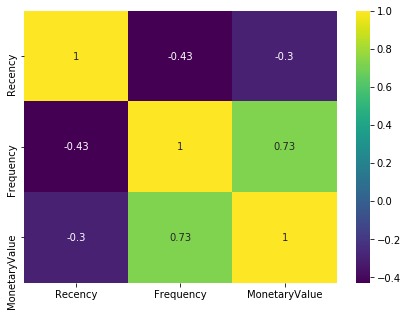

In [233]:
# Creating a correlation matrix
plt.figure(figsize=(7,5))
sns.heatmap(data=data.corr(),annot=True, cmap = "viridis")
plt.show()

As was to be shown. 0.73 - is a very strong correlation. Using both of these variables for segmentation is wrong!

In [234]:
#Let's transform MonetaryValue variable by dividing it on Frequency
data['MonetaryValue']=data['MonetaryValue']/data['Frequency']

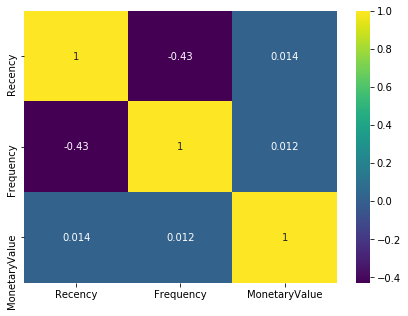

In [235]:
# Creating a correlation matrix again
plt.figure(figsize=(7,5))
sns.heatmap(data=data.corr(),annot=True, cmap = "viridis")
plt.show()

Much better and much more meaningful.

Now we can segment the rfm data. We'll do it by dividing each of 3 variables into 4 quantiles, assigning them a label from 1 to 4. Then it will be used for scoring each customer.

In [236]:
# Creating labels for Recency, Frequency and MonetaryValue
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

# Assigning these labels to percentile groups 
r_groups = pd.qcut(data['Recency'], q=4, labels=r_labels)
f_groups = pd.qcut(data['Frequency'], q=4, labels=f_labels)
m_groups = pd.qcut(data['MonetaryValue'], q=4, labels=m_labels)

# Creating new columns R F and M 
data = data.assign(R=r_groups.values, F=f_groups.values, M=m_groups.values)

# Calculating rfm_score and rfm_segment
def rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
data['rfm_score'] = data[['R','F','M']].sum(axis=1)
data['rfm_segment'] = data.apply(rfm, axis=1)
print(data.head())

             Recency  Frequency  MonetaryValue  R  F  M  rfm_score rfm_segment
customer_id                                                                   
1                  8          9     160.977778  4  4  1        9.0         441
2                129          2     731.100000  1  1  4        6.0         114
3                106          6     328.100000  2  3  2        7.0         232
4                196          2     196.450000  1  1  1        3.0         111
5                 17          5     580.560000  4  3  4       11.0         434


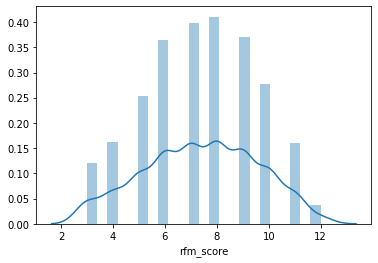

In [237]:
#let's visualize rfm_score
sns.distplot(data['rfm_score'])
plt.show()

Almost normal distribution as expected. The most popular scores are medium ones from 6 to 10. As is customary let's segment customers based on their rfm_score: Low, Medium, Top

In [238]:
def level(df):
    if df['rfm_score'] < 6:
        return 'Low'
    elif (df['rfm_score'] >= 6) and (df['rfm_score'] < 10):
        return 'Medium'
    else:
        return 'Top'

# Creating a new column level_rfm
data['level_rfm'] = data.apply(level, axis=1)

print(data.head())

             Recency  Frequency  MonetaryValue  R  F  M  rfm_score  \
customer_id                                                          
1                  8          9     160.977778  4  4  1        9.0   
2                129          2     731.100000  1  1  4        6.0   
3                106          6     328.100000  2  3  2        7.0   
4                196          2     196.450000  1  1  1        3.0   
5                 17          5     580.560000  4  3  4       11.0   

            rfm_segment level_rfm  
customer_id                        
1                   441    Medium  
2                   114    Medium  
3                   232    Medium  
4                   111       Low  
5                   434       Top  


In [239]:
# Let's calculate average values for each level
agg_level = data.groupby('level_rfm').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
  }).round(1)

print(agg_level)

           Recency  Frequency  MonetaryValue
level_rfm                                   
Low          148.7        2.7          287.7
Medium        68.0        4.7          452.1
Top           24.2        7.0          571.7


This is the spot where the majority of RFM analysis adherents stop. Each customer has a RFM score and corresponding RFM level - Low, Medium or Top. Indeed, customers are segmented - on average low RFM level are not frequent, made their last purchases long time ago and had small average check. However it is obvious that this Low RFM level group consists of heterogeneous (in terms of behaviour) customers - some may have high monetary value score, some may did their first purchase only yesterday, etc. 

I am convinced, that such type of customer segmentation is ineffective and RFM level variable is useless as absolutely different types of customers are grouped together. But what about rfm_segment variable that keeps these customers separated? Let's take a look.

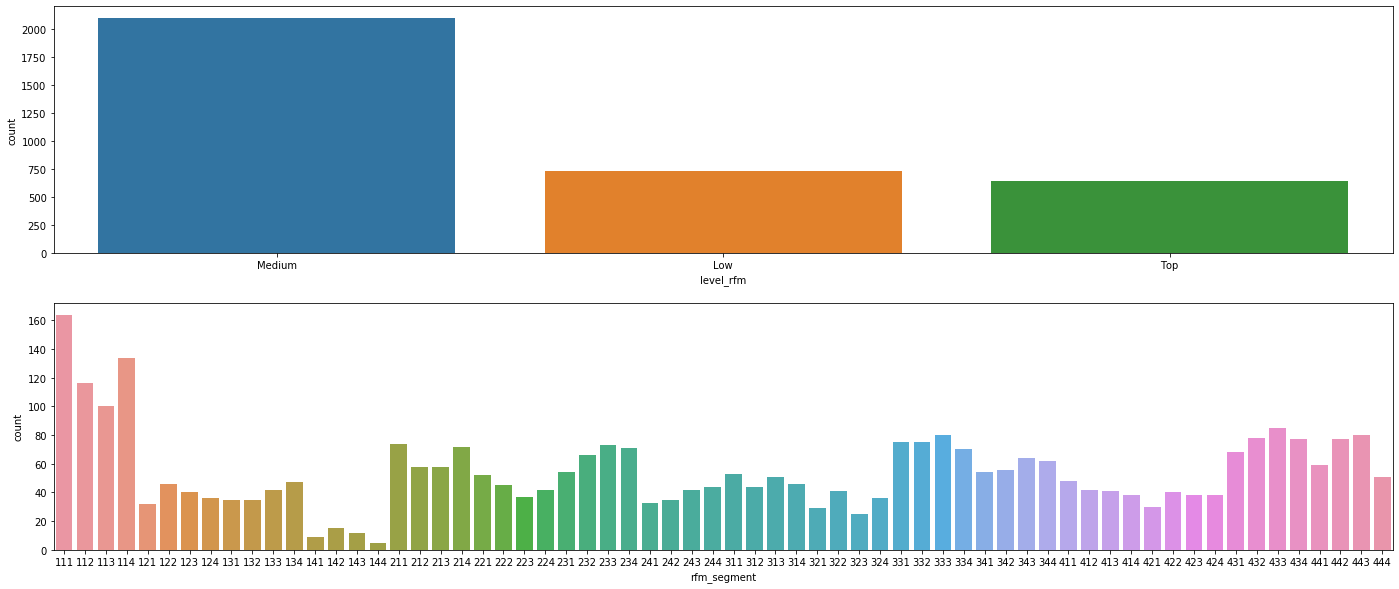

In [240]:
#Visualizing level_rfm and rfm_segment
plt.figure(figsize=(24,10))
plt.subplot(2, 1, 1)
sns.countplot(data['level_rfm'])
plt.subplot(2, 1, 2)
sns.countplot(data['rfm_segment'])
plt.show()

First of all we can see that there are too many segments - 64. Even if we assigned labels from 1 to 3, not from 1 to 4, we still would have 27 segments. Anyway it is too many for marketing purposes since it would be tremendously difficult to target all 27 or 64 segments differently. Ideally we would like to have less than 10 segments. 
However, rfm segments can be useful if we want to examine particular groups of customers.

Thus, let's analyze a bit what we see on the rfm_segment countplot. Obviously 2 groups of rfm segments stand out: 
1. The group of the largest segments:111,112,113,114. These customers made only 1-2 orders relatively long time ago and never appeared again. Most of these people probably just needed to buy a bike and was never going to become frequent customers.

2. The group of the smallest segments: 141,142,143,144. This is much more interesting. These people were our loyal frequent customers, but something happened and they stopped buying anything at all! We should be happy that there are only a few dozens of such customers, but it would be great anyway to examine this group further with the similar group 241,242,243,244. Maybe we will unlock some insights and figure out who are these people

Finally, it looks like it makes sense to create not only rfm segments, but rf(only recency and frequency) segments as well.


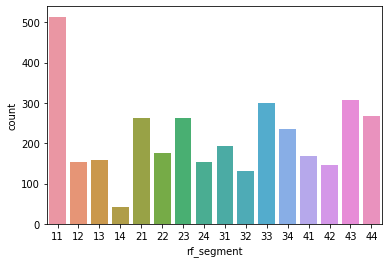

In [241]:
# Calculating rf_segment
def rf(x): return str(x['R']) + str(x['F'])
data['rf_segment'] = data.apply(rf, axis=1)
# Visualizeing rf_segments
sns.countplot(data['rf_segment'])
plt.show()

In [242]:
#Let's merge our customer level data with customer demographics and addresses dataframe
df = pd.merge(data,cust, on='customer_id', how='inner')
#We are interested in only two rf_segments: 14,24 (loyal customers that we lost)
df1=df[(df['rf_segment']=='14') | (df['rf_segment']=='24')]

Let's now examine demographics of ex-loyal customers and compare them with a whole dataset demographics

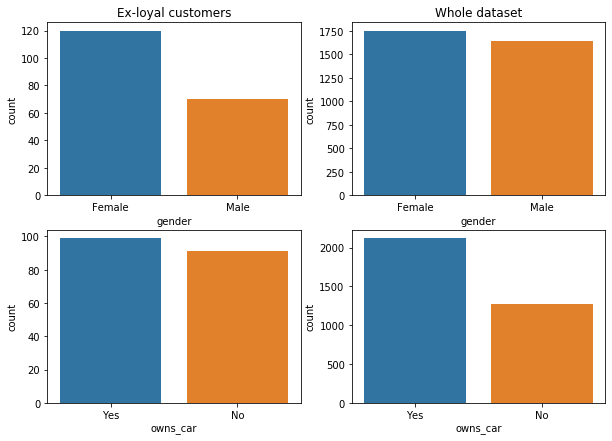

Ex-loyal customers average age 43.61052631578947
Whole dataset customers average age 42.80966411314083


In [243]:
#Visualizing count plots for gender and owns_car variables
plt.figure(figsize=(10,7))
plt.subplot(2, 2, 1)
sns.countplot(df1['gender'])
plt.title("Ex-loyal customers")
plt.subplot(2, 2, 2)
sns.countplot(df['gender'])
plt.title("Whole dataset")
plt.subplot(2, 2, 3)
sns.countplot(df1['owns_car'])
plt.subplot(2, 2, 4)
sns.countplot(df['owns_car'])
plt.show()
# Comparing average ages of ex-loyal customers and whole dataset
print("Ex-loyal customers average age "+str(df1['age'].mean()))
print("Whole dataset customers average age "+str(df['age'].mean()))

The most loyal customers we lost were women. Also, almost half of ex-loyal customers did not have a car, while in the whole dataset only 35% does not have a car. Maybe some of those ex-customers just bought a car and this is why they stopped to buy accessories for bikes? Or maybe the store started targeting people for whom bicycles are just a hobbie, not a main vehicle? Anyway it is valuable information for a marketing team.

This short analysis was just an example of how rfm_segments variable can be used for detailed examination of particular group of customers. Let's go back to our initial dataframe and examine relationships between all the variables we created during RFM analysis and demographic data

Thus, correlation matrix will help us examine relationships between continuous variables: Recency, Frequency, MonetaryValue, rfm_score and age

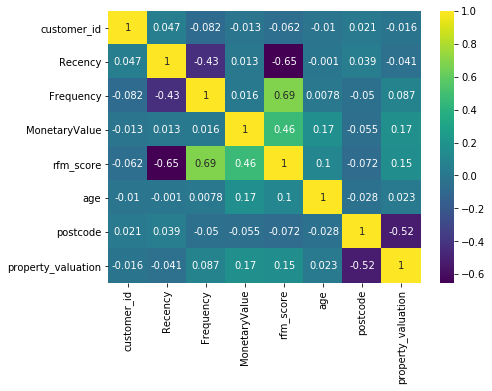

In [244]:
# Creating a correlation matrix
plt.figure(figsize=(7,5))
sns.heatmap(data=df.corr(),annot=True, cmap = "viridis")
plt.show()

No meaningful correlations. Age is not correlated with any of RFM variables. 
Now we will use boxplots to identify relationships between continuous and categorical variables

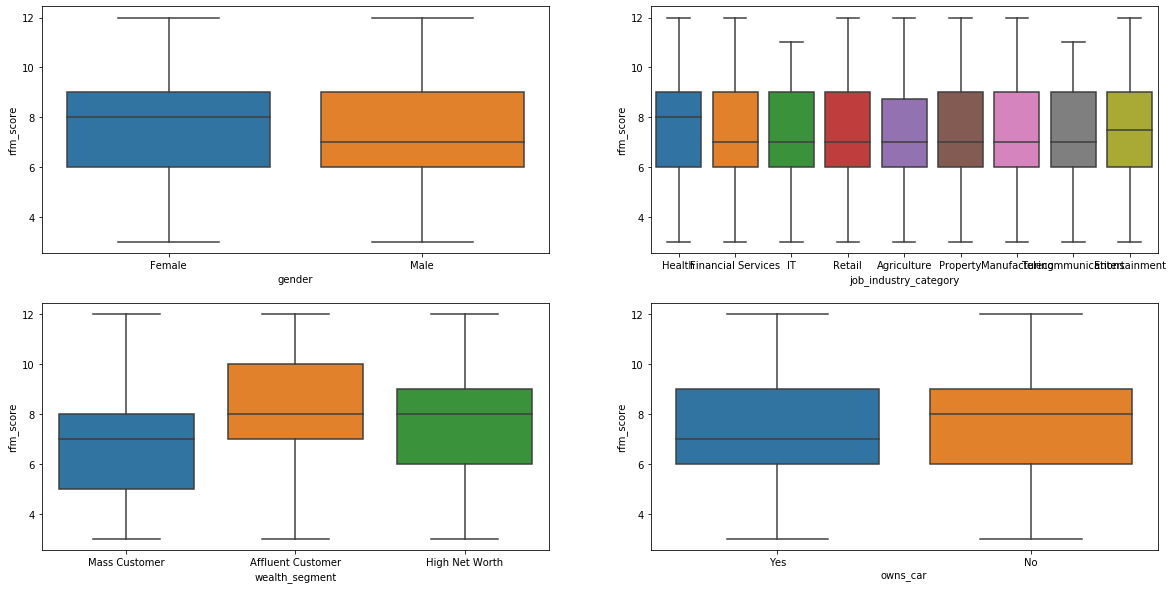

In [245]:
# rfm_score and demographic variables
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
sns.boxplot(x='gender',y='rfm_score',data=df)

plt.subplot(2, 2, 2)
sns.boxplot(x='job_industry_category',y='rfm_score',data=df)

plt.subplot(2, 2, 3)
sns.boxplot(x='wealth_segment',y='rfm_score',data=df)

plt.subplot(2, 2, 4)
sns.boxplot(x='owns_car',y='rfm_score',data=df)

plt.show()

As it was expected higher the rfm_score lesser the share of mass customers. Probably it is caused mostly by Monetary value

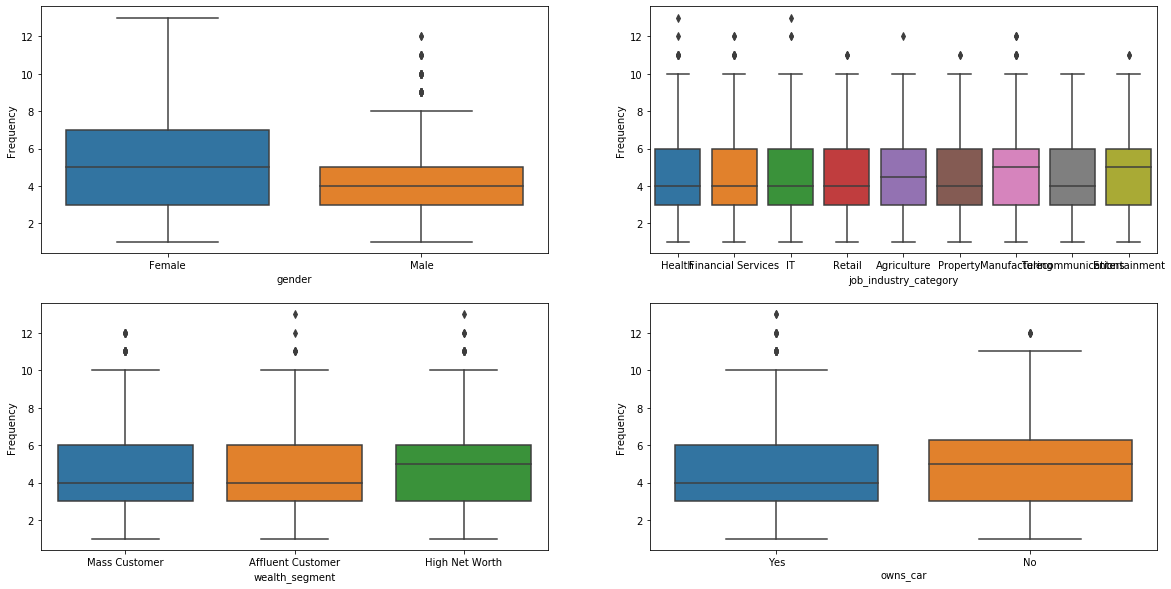

In [246]:
#Frequency and demographic variables
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
sns.boxplot(x='gender',y='Frequency',data=df)

plt.subplot(2, 2, 2)
sns.boxplot(x='job_industry_category',y='Frequency',data=df)

plt.subplot(2, 2, 3)
sns.boxplot(x='wealth_segment',y='Frequency',data=df)

plt.subplot(2, 2, 4)
sns.boxplot(x='owns_car',y='Frequency',data=df)

plt.show()

Females tend to buy from the store much more frequently than males. Let's verify it statistically with ANOVA test

We must first check these assumptions for ANOVA:
1. The population from which samples are drawn should be normally distributed. - TRUE
2. Independence of cases: the sample cases should be independent of each other. - TRUE
3. Homogeneity of variance: Homogeneity means that the variance among the groups should be approximately equal. - Let's check it

In [247]:
print("Standard deviation for Males - "+ str(df[df['gender']=='Male']['Frequency'].std()))
print("Standard deviation for Females - "+ str(df[df['gender']=='Female']['Frequency'].std()))

Standard deviation for Males - 2.0684465112122536
Standard deviation for Females - 2.3281786900687966


Variances are more or less similar. We can do ANOVA now.

In [248]:
import scipy.stats as stats
stats.f_oneway(df['Frequency'][df['gender'] == 'Male'],
               df['Frequency'][df['gender'] == 'Female'])

F_onewayResult(statistic=158.7397807236696, pvalue=1.3217592996668553e-35)

P-value is extremely low - females indeed are more frequent customers

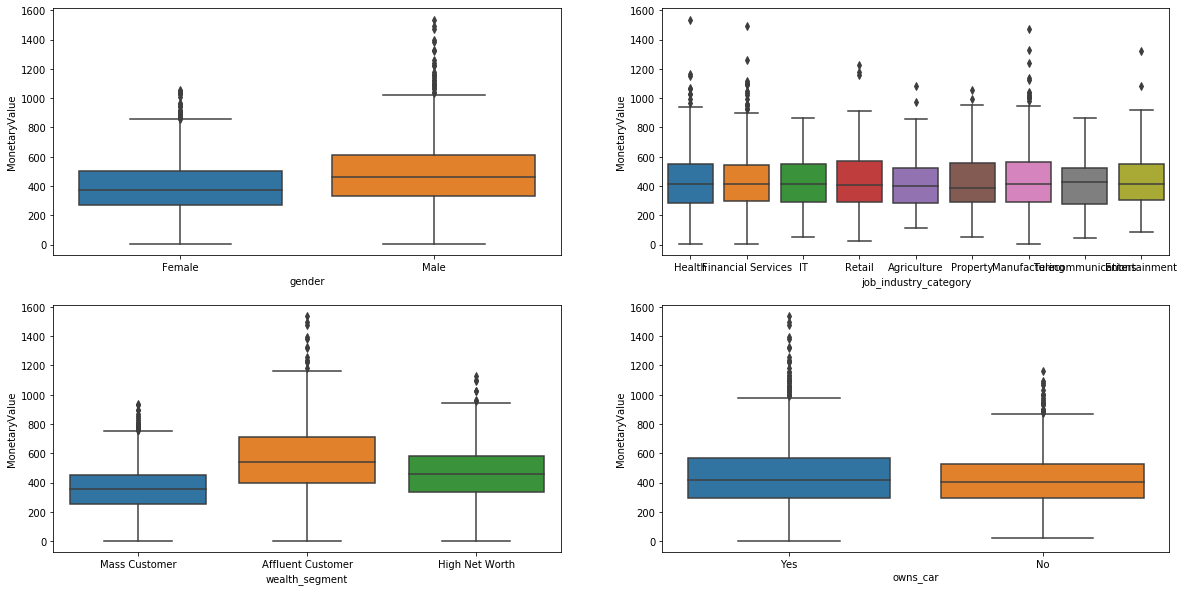

In [249]:
#MonetaryValue and demographic variables
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
sns.boxplot(x='gender',y='MonetaryValue',data=df)

plt.subplot(2, 2, 2)
sns.boxplot(x='job_industry_category',y='MonetaryValue',data=df)

plt.subplot(2, 2, 3)
sns.boxplot(x='wealth_segment',y='MonetaryValue',data=df)

plt.subplot(2, 2, 4)
sns.boxplot(x='owns_car',y='MonetaryValue',data=df)

plt.show()

Affluent customers spend more than High Net Worth. High Net Worth - more than Mass Customers. It is expected.
Males tend to spend more at a time than females. Let's verify it statistically with ANOVA test.

In [250]:
print("Standard deviation for Males - "+ str(df[df['gender']=='Male']['MonetaryValue'].std()))
print("Standard deviation for Females - "+ str(df[df['gender']=='Female']['MonetaryValue'].std()))

Standard deviation for Males - 217.24634350911074
Standard deviation for Females - 173.28633529072323


Variances are more or less similar. We can do ANOVA now.

In [251]:
stats.f_oneway(df['MonetaryValue'][df['gender'] == 'Male'],
               df['MonetaryValue'][df['gender'] == 'Female'])

F_onewayResult(statistic=174.0196026482143, pvalue=8.700107627435316e-39)

P-value is extremely low - Males indeed spend more than females

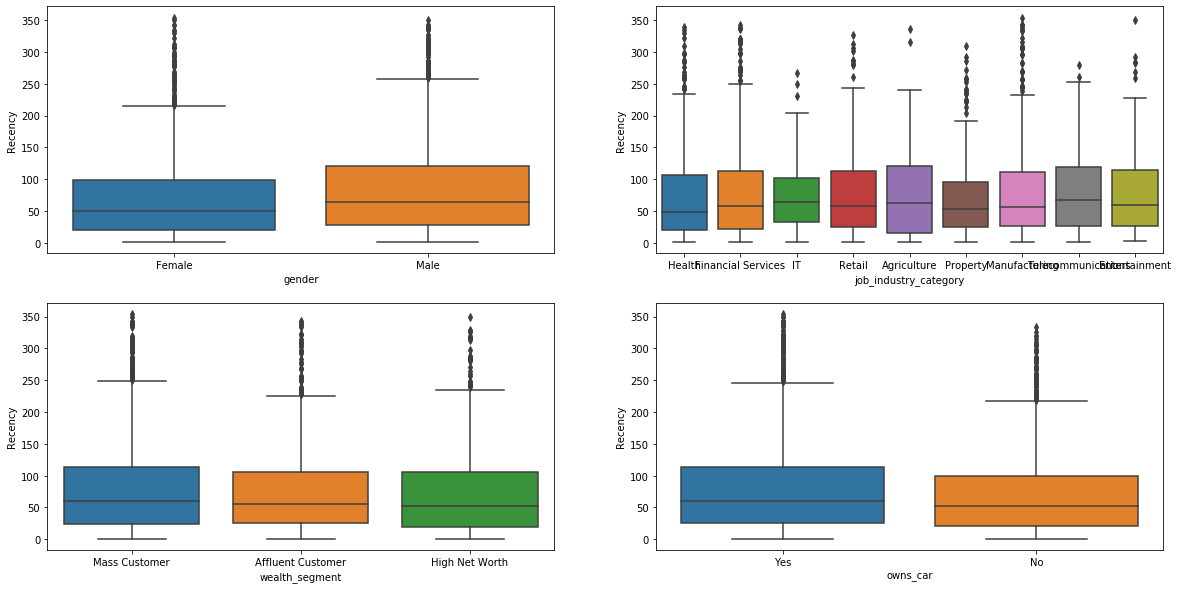

In [252]:
#Recency and demographic variables
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
sns.boxplot(x='gender',y='Recency',data=df)

plt.subplot(2, 2, 2)
sns.boxplot(x='job_industry_category',y='Recency',data=df)

plt.subplot(2, 2, 3)
sns.boxplot(x='wealth_segment',y='Recency',data=df)

plt.subplot(2, 2, 4)
sns.boxplot(x='owns_car',y='Recency',data=df)

plt.show()

Most recent customers are females and those who don't have a car. Let's verify it with ANOVA

In [253]:
print("Standard deviation for Males - "+ str(df[df['gender']=='Male']['Recency'].std()))
print("Standard deviation for Females - "+ str(df[df['gender']=='Female']['Recency'].std()))
print("Standard deviation for owns_car - Yes - "+ str(df[df['owns_car']=='Yes']['Recency'].std()))
print("Standard deviation for owns_car - No - "+ str(df[df['owns_car']=='No']['Recency'].std()))

Standard deviation for Males - 75.79395565131851
Standard deviation for Females - 65.1613906374799
Standard deviation for owns_car - Yes - 72.77374030030751
Standard deviation for owns_car - No - 67.50160188796286


Variances are more or less similar. We can do ANOVA now.

In [254]:
print(stats.f_oneway(df['Recency'][df['gender'] == 'Male'],
               df['Recency'][df['gender'] == 'Female']))
print(stats.f_oneway(df['Recency'][df['owns_car'] == 'Yes'],
               df['Recency'][df['owns_car'] == 'No']))

F_onewayResult(statistic=42.97327850091002, pvalue=6.390846833230329e-11)
F_onewayResult(statistic=9.32437213572768, pvalue=0.0022788068646670168)


Both P-values are extremely low - more recent customers indeed are females and those who don't have a car. However, we remember that ex-loyal customers did not have cars too. Probably it means that those churned customers just bought cars and that is why they churned, since the store is still popular among no car owners.

Let's now take a look at geographical data. To plot customers' location on a map we need to know latitude and longitude, but we have only postcode. It is not a problem - pgeocode package for Python is able to assign latitude and longitude values for each postcode.

In [255]:
import pgeocode
import plotly.express as px
nomi = pgeocode.Nominatim('au')
# Test example - Extract Latitude and Longitude
print(nomi.query_postal_code("2016")[9])
print(nomi.query_postal_code("2016")[10])

-33.8934
151.2067


In [256]:
#creating latitude and longitude variables out of postcode
df["latitude"] = df["postcode"].apply(lambda x: nomi.query_postal_code(x)[9])
df["longitude"] = df["postcode"].apply(lambda x: nomi.query_postal_code(x)[10])

In [257]:
# Plotting customers' location on a map
fig = px.scatter_mapbox(df, lat="latitude", lon="longitude",color='MonetaryValue', zoom=3.5, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Unfortunately, geographical data did not tell us anything new. The only pattern we found is that customers with high average spendings are concentrated in big cities near coasts. All customers from rural area have low monetary value. However, it was expected. 

On the other hand, our store operates only online. Obviously, if it were a physical store we would find much more patterns and insights. 

Conclusion for the RFM analysis part. RFM analysis helped us unlock some insights and form a better understanding of customer groups. However, we did not find anything extraordinary, the most useful were ordinary continious variables Recency, Frequency and Monetary Value. Categorical variables like rfm_score and level_rfm were absolutely useless. I would recommend to focus mostly on rfm_segment variable since it segments customers on many groups with different combinations of R F M scores and in some cases it makes sense to examine some of these combinations.

Let's see if unsupervised machine learning algorithm K-means will reinvigorate rfm features that we engineered!

## 7. K-means clustering step

### 7.1 Data preparation for clustering

#### 7.1.1 Feature selection
K-means algorithm is effective only if input features are continuous. Let's drop categorical features

In [258]:
df_k=df[['customer_id','Recency','Frequency','MonetaryValue','age']]

Now let's create a correlation matrix to verify that there is no multicollinearity between selected features

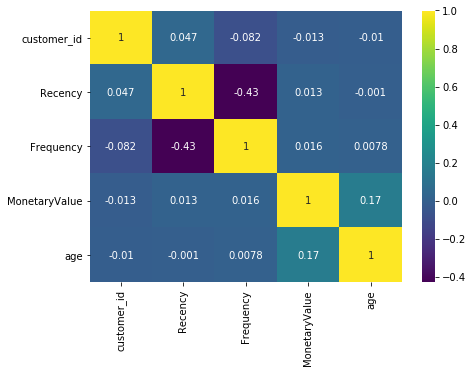

In [259]:
plt.figure(figsize=(7,5))
sns.heatmap(data=df_k.corr(),annot=True, cmap = "viridis")
plt.show()

#### 7.1.2 Dealing with missing values

In [260]:
# Checking how many missing values there are in the dataset
df_k.isnull().sum()

customer_id      0
Recency          0
Frequency        0
MonetaryValue    0
age              0
dtype: int64

We are lucky - no missing values at all

#### 7.1.3 Removing outliers

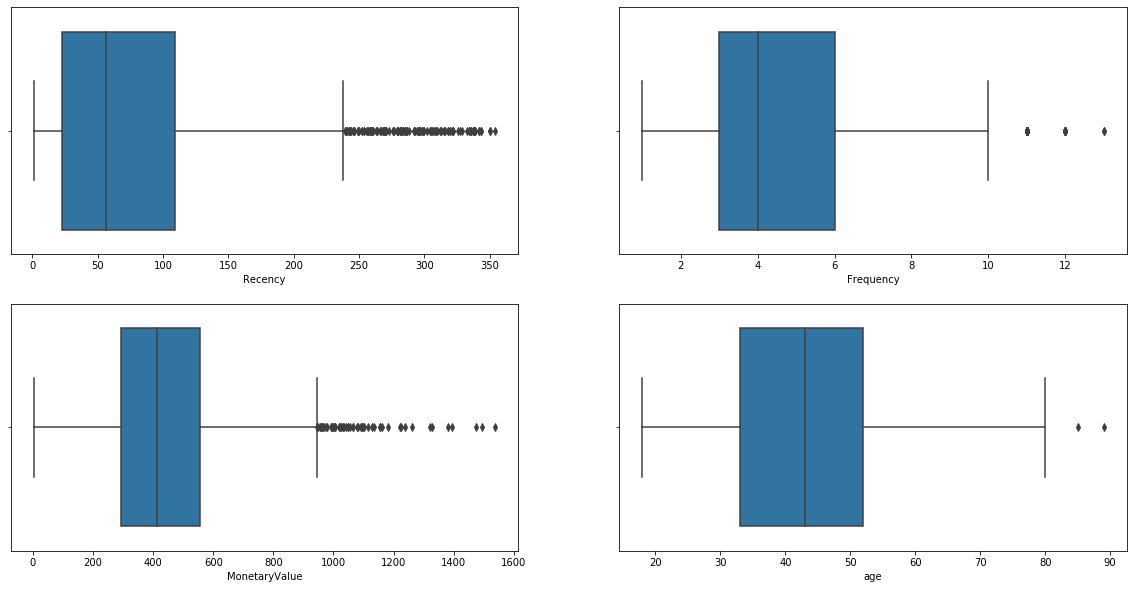

In [261]:
# Boxplots will help us identify outliers
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
sns.boxplot(x='Recency',data=df_k)

plt.subplot(2, 2, 2)
sns.boxplot(x='Frequency',data=df_k)

plt.subplot(2, 2, 3)
sns.boxplot(x='MonetaryValue',data=df_k)

plt.subplot(2, 2, 4)
sns.boxplot(x='age',data=df_k)

plt.show()

No outliers in Recency. For MonetaryValue, Frequency and age we will drop only the most extreme values

In [262]:
#Starting with MonetaryValue
Q1 = df_k.MonetaryValue.quantile(0.25)
Q3 = df_k.MonetaryValue.quantile(0.75)
IQR = Q3 - Q1
df_k = df_k[(df_k.MonetaryValue <= (Q3 + 2.5*IQR))]

In [263]:
#Frequency
Q1 = df_k.Frequency.quantile(0.25)
Q3 = df_k.Frequency.quantile(0.75)
IQR = Q3 - Q1
df_k = df_k[(df_k.Frequency <= (Q3 + 1.5*IQR))]

In [264]:
#age
Q1 = df_k.age.quantile(0.25)
Q3 = df_k.age.quantile(0.75)
IQR = Q3 - Q1
df_k = df_k[(df_k.age <= (Q3 + 1.5*IQR))]

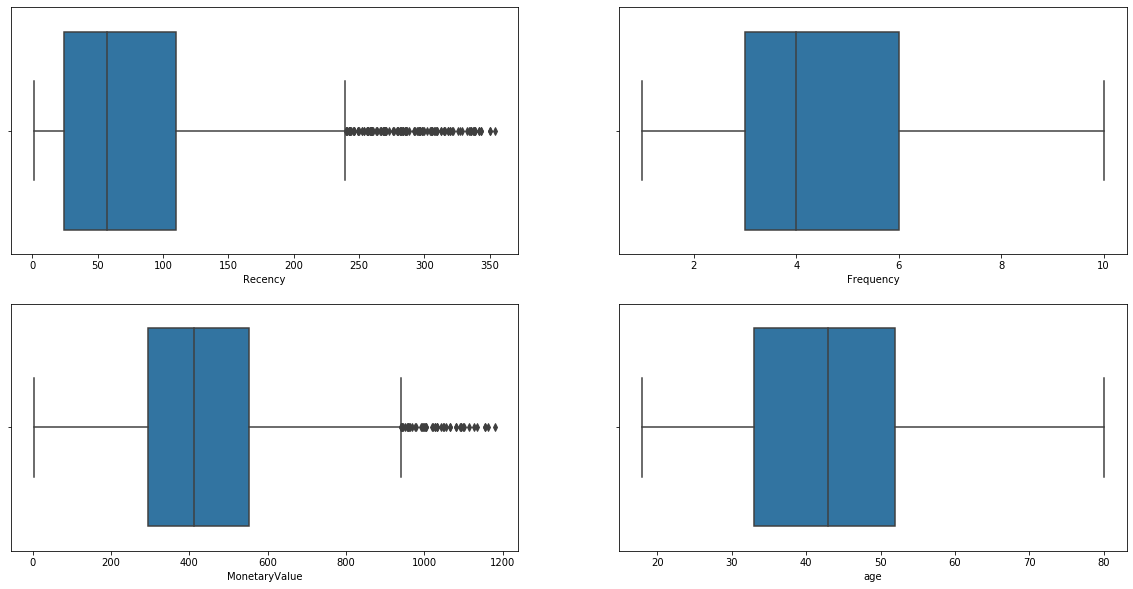

In [265]:
#Checking with boxplots again
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
sns.boxplot(x='Recency',data=df_k)

plt.subplot(2, 2, 2)
sns.boxplot(x='Frequency',data=df_k)

plt.subplot(2, 2, 3)
sns.boxplot(x='MonetaryValue',data=df_k)

plt.subplot(2, 2, 4)
sns.boxplot(x='age',data=df_k)

plt.show()

#### 7.1.4 Managing skewed features

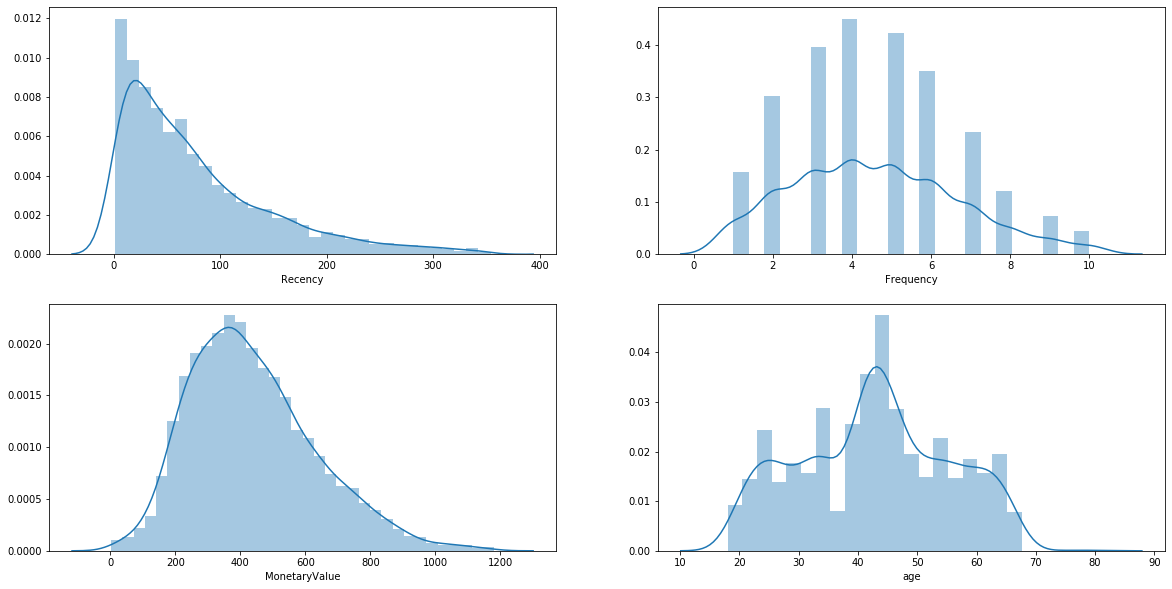

In [266]:
#Distribution plots will help us identify skewed variables
plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
sns.distplot(df_k['Recency'])

plt.subplot(2, 2, 2)
sns.distplot(df_k['Frequency'])

plt.subplot(2, 2, 3)
sns.distplot(df_k['MonetaryValue'])

plt.subplot(2, 2, 4)
sns.distplot(df_k['age'])

plt.show()

Frequency and age are more or less symmetric. We have to transform only Recency and MonetaryValue

In [267]:
df_k['Recency_log'] = np.log(df_k['Recency'])
df_k['MonetaryValue_log'] = np.log(df_k['MonetaryValue'])

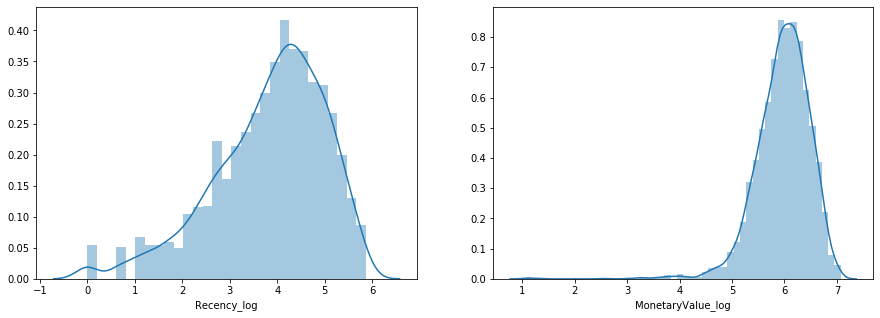

In [268]:
#checking new distributions
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.distplot(df_k['Recency_log'])

plt.subplot(1, 2, 2)
sns.distplot(df_k['MonetaryValue_log'])
plt.show()

Recency still is not symmetric, but at least it is less skewed

#### 7.1.5 Scaling features

In [269]:
#Scaling with StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_k)
df_normalized=scaler.transform(df_k)
#Creating new dataframe with scaled features
df_normalized = pd.DataFrame(data=df_normalized, index=df_k.index, columns=df_k.columns)

### 7.2 Assessing clustering tendency

In [270]:
#Importing hopkins statistic to assess clustering tendency
from pyclustertend import hopkins

In [271]:
#Assessing clustering tendency
print('Clustering tendency of the full dataset - '
      + str(hopkins(df_normalized[['Recency_log','Frequency','MonetaryValue_log','age']], 3332)))
print('Only Recency, Frequency, MonetaryValue clustering tendency  - '
      + str(hopkins(df_normalized[['Recency_log','Frequency','MonetaryValue_log']], 3332)))
print('Only Recency, Frequency, age clustering tendency  - '
      + str(hopkins(df_normalized[['Recency_log','Frequency','age']], 3332)))
print('Only Recency, age, MonetaryValue clustering tendency  - '
      + str(hopkins(df_normalized[['Recency_log','age','MonetaryValue_log']], 3332)))
print('Only age, Frequency, MonetaryValue clustering tendency  - '
      + str(hopkins(df_normalized[['age','Frequency','MonetaryValue_log']], 3332)))


Clustering tendency of the full dataset - 0.13776487510992247
Only Recency, Frequency, MonetaryValue clustering tendency  - 0.07043976132414102
Only Recency, Frequency, age clustering tendency  - 0.2199964485784742
Only Recency, age, MonetaryValue clustering tendency  - 0.11242222079068324
Only age, Frequency, MonetaryValue clustering tendency  - 0.06668419135073517


Lower hopkins statistic value - better "clusterability" of the dataset. 2 combinations of features showed the best results: Recency, Frequency, MonetaryValue and age, Frequency, MonetaryValue. We will cluster on both combinations of features

### 7.3 Choosing k-number of clusters

We will try 3 different methods:
1. Choosing K - number of clusters based on a Silhouette scores
2. Hierarchical clustering
3. Elbow method

#### 7.3.1 Choosing K - number of clusters based on a Silhouette scores

In [272]:
from pyclustertend import assess_tendency_by_metric
print('Recency, Frequency, MonetaryValue - ' 
      + str(assess_tendency_by_metric(df_normalized[['Recency_log','Frequency','MonetaryValue_log']], n_cluster=10)))
print('age, Frequency, MonetaryValue - ' 
      + str(assess_tendency_by_metric(df_normalized[['age','Frequency','MonetaryValue_log']], n_cluster=10)))

Recency, Frequency, MonetaryValue - (2, array([0.27847676, 0.2573483 , 0.26786203, 0.23044297, 0.24132399,
       0.24297458, 0.23995672, 0.24074289, 0.23386778]))
age, Frequency, MonetaryValue - (2, array([0.29399803, 0.27404295, 0.28240117, 0.27377525, 0.27752567,
       0.26304232, 0.26127195, 0.26216387, 0.25250934]))


The best results achieved with 2 and 4 clusters for both combinations of features

#### 7.3.2 Hierarchical clustering

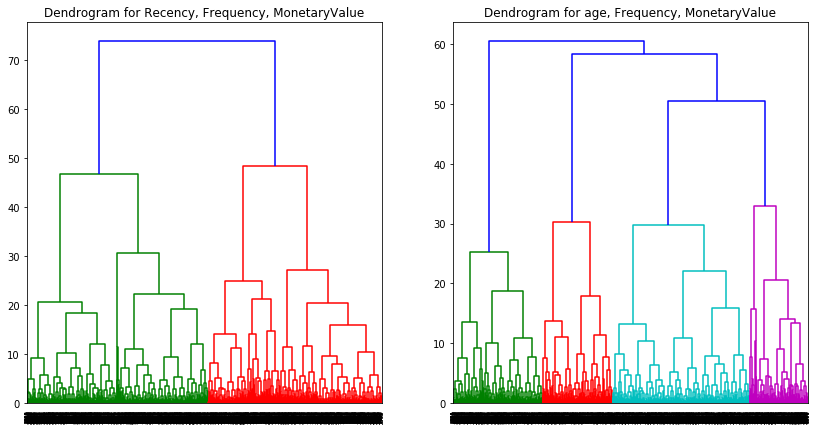

In [273]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(14, 7))  
plt.subplot(1, 2, 1)
plt.title("Dendrogram for Recency, Frequency, MonetaryValue")  
dend = shc.dendrogram(shc.linkage(df_normalized[['Frequency','Recency_log','MonetaryValue_log']], method='ward'))
plt.subplot(1, 2, 2)
plt.title("Dendrogram for age, Frequency, MonetaryValue")  
dend = shc.dendrogram(shc.linkage(df_normalized[['age','Frequency','MonetaryValue_log']], method='ward'))
plt.show()

The dendrograms show that the best k would be 2 and 4 for Recency, Frequency, MonetaryValue and k=4 for age, Frequency, MonetaryValue.

#### 7.3.3 Elbow method

In [274]:
from sklearn.cluster import KMeans
#Recency, Frequency, MonetaryValue
sse={}
for k in range(1,11):
    kmeans = KMeans (n_clusters=k, random_state=1)
    kmeans.fit(df_normalized[['Frequency','Recency_log','MonetaryValue_log']])
    sse[k] = kmeans.inertia_

In [275]:
#age, Frequency, MonetaryValue
sse2={}
for k in range(1,11):
    kmeans = KMeans (n_clusters=k, random_state=1)
    kmeans.fit(df_normalized[['age','Frequency','MonetaryValue_log']])
    sse2[k] = kmeans.inertia_

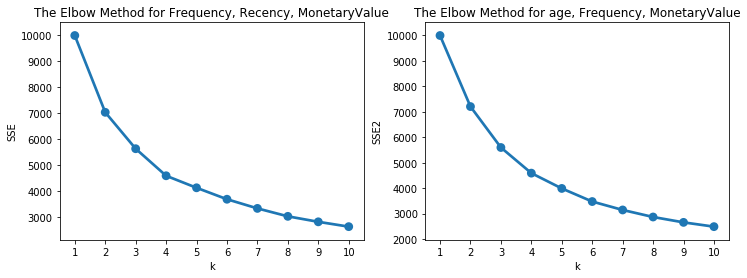

In [276]:
#Plotting elbow method graphs
plt.figure(figsize=(12, 4))  
plt.subplot(1, 2, 1)
plt.title('The Elbow Method for Frequency, Recency, MonetaryValue')
plt.xlabel('k');
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.subplot(1, 2, 2)
plt.title('The Elbow Method for age, Frequency, MonetaryValue')
plt.xlabel('k');
plt.ylabel('SSE2')
sns.pointplot(x=list(sse2.keys()), y=list(sse2.values()))
plt.show()

Elbow method graphs show that the best k for both combinations of features will be k=4

All three methods claim with one voice that k=4 is the best choice for both datasets. Perfect!

### 7.4 K-Means clustering

In [277]:
#starting with Recency, Frequency, MonetaryValue
kmeans=KMeans(n_clusters=4, random_state=1)
kmeans.fit(df_normalized[['Frequency','Recency_log','MonetaryValue_log']])
cluster_labels=kmeans.labels_

rfm=df_k.assign(Cluster=cluster_labels)
print(rfm.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'age': 'mean',
    'MonetaryValue': ['mean','count'],
}).round(1))

        Recency Frequency   age MonetaryValue      
           mean      mean  mean          mean count
Cluster                                            
0         108.9       3.3  39.4         223.2   660
1          54.5       6.9  43.2         446.9   928
2          10.3       4.9  42.8         443.2   630
3         117.1       3.2  44.4         556.9  1114


In [278]:
#Comparing clusters' means with whole dataset means
print('Average Recency - '+str(df_k.Recency.mean()))
print('Average Frequency - '+str(df_k.Frequency.mean()))
print('Average age - '+str(df_k.age.mean()))
print('Average MonetaryValue - '+str(df_k.MonetaryValue.mean()))

Average Recency - 77.83193277310924
Average Frequency - 4.575330132052821
Average age - 42.76650660264106
Average MonetaryValue - 438.67859807018095


Let's try to understand these clusters from a business point of view.

Cluster 0 - rare customers that made last orders relatively long time ago and have very low average spending value. Let's call them Occasional Customers

Cluster 1 - it is just the most frequent customers. They are loyal and their orders are significant in terms of spendings. We'll call them Loyal Customers

Cluster 2 - These are the most recent customers. Name of this cluster will be Current Customers

Cluster 3 - They made their last orders long time ago. Unfortunately, they were very valuable for us in terms of profitability since their MonetaryValue is the highest among 4 cluster. Let's call them Churned Customers

In [279]:
#Renaming obtained clusters
d1={0:"Occasional Customers", 1:"Loyal Customers", 2: "Current Customers", 3:"Can't Lose Them"}
rfm.loc[:,"rfm_based"]=rfm.loc[:,"Cluster"].map(d1)

In [280]:
#Let's do clustering for the second set of features age, Frequency, MonetaryValue
kmeans=KMeans(n_clusters=4, random_state=1)
kmeans.fit(df_normalized[['Frequency','age','MonetaryValue_log']])
cluster_labels=kmeans.labels_

afm=df_k.assign(Cluster=cluster_labels)
print(afm.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'age': 'mean',
    'MonetaryValue': ['mean','count'],
}).round(1))

        Recency Frequency   age MonetaryValue      
           mean      mean  mean          mean count
Cluster                                            
0          82.4       4.1  27.6         282.8   854
1          93.3       3.3  44.9         591.6  1093
2          83.4       3.9  58.4         298.3   591
3          47.5       7.2  44.5         500.3   794


Let's try to understand these clusters as well

Cluster 0 - This is the youngest cluster of customers. Also they don't spend much.

Cluster 1 - These customers are rare but profitable.

Cluster 2 - They are just the most senior group of customers

Cluster 3 - The most frequent and the most loyal customers


As we can see from the clusters above age played the key role in clustering process. No doubt that we will find fewer useful insights with such clusters. 
That is why from here on we will be working only with rfm based clusters

In [281]:
#Merging old customer level dataset with rfm based clusters
rfm=rfm[['customer_id','rfm_based']]
df = pd.merge(df, rfm, on='customer_id', how='inner')
print(df.head())

   customer_id  Recency  Frequency  MonetaryValue  R  F  M  rfm_score  \
0            1        8          9     160.977778  4  4  1        9.0   
1            2      129          2     731.100000  1  1  4        6.0   
2            4      196          2     196.450000  1  1  1        3.0   
3            5       17          5     580.560000  4  3  4       11.0   
4            6       65          3     413.633333  2  1  3        6.0   

  rfm_segment level_rfm  ...  gender age  job_industry_category  \
0         441    Medium  ...  Female  67                 Health   
1         114    Medium  ...    Male  40     Financial Services   
2         111       Low  ...    Male  59                     IT   
3         434       Top  ...  Female  43                    NaN   
4         213    Medium  ...    Male  54                 Retail   

      wealth_segment owns_car postcode  property_valuation  latitude  \
0      Mass Customer      Yes     2016                  10  -33.8934   
1      Mass Cu

gender                  Female      Male
rfm_based                               
Can't Lose Them       0.366248  0.633752
Current Customers     0.552381  0.447619
Loyal Customers       0.618534  0.381466
Occasional Customers  0.583333  0.416667


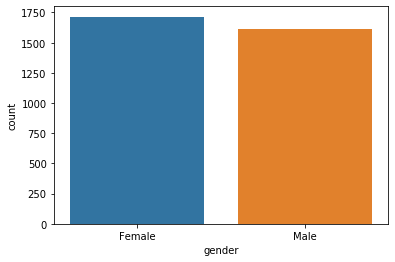

In [282]:
#Let's start examination of clusters with gender
crosstab = pd.crosstab(df['rfm_based'], df['gender'], normalize='index')
print(crosstab)
#Comparing with whole dataset
sns.countplot(df['gender'])
plt.show()

Our loyal and recent customers are mostly females, while customers that we have lost are mostly males. Why the store is so attractive to females and not so attractive to males? Priceless information for the marketing team!

wealth_segment        Affluent Customer  High Net Worth  Mass Customer
rfm_based                                                             
Can't Lose Them                0.318671        0.265709       0.415619
Current Customers              0.211111        0.295238       0.493651
Loyal Customers                0.259698        0.262931       0.477371
Occasional Customers           0.122727        0.193939       0.683333


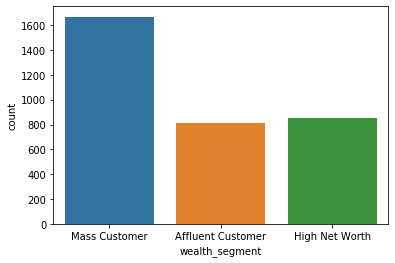

In [283]:
# Wealth segment
crosstab1 = pd.crosstab(df['rfm_based'], df['wealth_segment'], normalize='index')
print(crosstab1)
sns.countplot(df['wealth_segment'])
plt.show()

Proportion of the affluent customers in the dataset is 23%, in Churned Customers cluster - 32%. Why we have lost so many affluent customers? Maybe the store should start selling more goods of high price category? Another question for management team!

owns_car                    No       Yes
rfm_based                               
Can't Lose Them       0.339318  0.660682
Current Customers     0.377778  0.622222
Loyal Customers       0.438578  0.561422
Occasional Customers  0.342424  0.657576


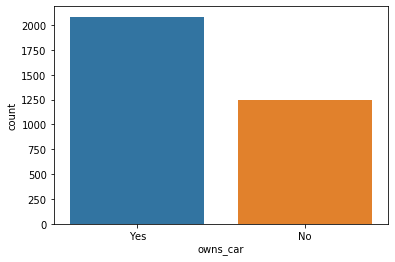

In [284]:
#Owns_car
crosstab2 = pd.crosstab(df['rfm_based'], df['owns_car'], normalize='index')
print(crosstab2)
sns.countplot(df['owns_car'])
plt.show()

Among loyal customers there are much more people without cars than in other clusters. Possibly it means that the store is attractive for people who use bicycle as a main vehicle, not just hobby. How not to lose other categories of customers? It is definetely something to think about for the marketing team

## 8. Conclusion

We used the dataset to demostrate that even simple machine learning algorithms like K-means are able to bring a lot of value to traditional customer segmentation technics like cohort analysis and RFM analysis. Indeed, K-means analysis as a third step unlocked much more insights in the data than RFM analysis alone. 

It is important to note that K-means clustering is a very simple tool and requires only basic understanding of statistics and knowledge of a few assumptions. So, it should be used by citizen business analists or marketing specialists, not only data scientists.

Two recommendations for future users of RFM analysis:
1. It is much more meaningful to use average monetary value instead of sum.
2. Always consider machine learning clustering algorithms as a second step of RFM analysis. 
